# A TabPy Bootcamp 
### Functions written in Python and referenced from Tableau

By: Alfredo Pirrone<br />
Date: November 12, 2017<br />
Version: 1.0

In the Tableau forums, in march 2017, [Nico Rabi](https://community.tableau.com/people/nico.raby) posted a question under the header [TabPy remote function call](https://community.tableau.com/message/592086#592086), It looks like he was not satisfied with the answer, as he did not marked any of the replies received as "correct answer". Maybe he expected a bit more explanation on what was going on, and for sure he has not read [Tableau and Python Integration](https://community.tableau.com/docs/DOC-10856) by [Bora Beran](https://community.tableau.com/people/bora.beran). If you have not read it either, please go and read it now and come back afterwards.

I will use Nico's case to illustrate the connection between Tableau and TabPy server, hopefully helping the reader to understand the basic concepts involved in connecting both environments. 

This notebook is aimed to the uninitiated. I believe you will finf it more useful   but assumes you have already successfully installed tabpy in your machine, and that you have succeed in connecting Tableau to the tabpy server.

### 1. Establishing a connection
Let us start by establishing a connection with the TabPy server, so that we can deploy our functions

In [75]:
import tabpy_client
conn = tabpy_client.Client("http://localhost:9004/")

I am using python 3.6.3. If you are using python 2.7, it might be necessary to adjust part of the code.

Let's check what version you are using:

In [76]:
import sys
print(sys.version)

3.6.3 |Anaconda, Inc.| (default, Nov  8 2017, 18:10:31) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


### 2. What was wrong with the simple "add" function

Nico tried to add two numbers in Tableau using the following function:

In [77]:
def add_simple(a, b):
    """ adds two objects and returns an object """
    return(a + b)

# let us deploy the function to have it available in Tableau
conn.deploy('add_simple', add_simple, 'adds two objects and returns an object', override = True)

Please open the enclosed workbook "tabpy_client_example.twb" and go to sheet "Add Simple"

Trying to use this function in Tableau will produce an error: *"Unexpected number of results returned by SCRIPT function. Function expected 10 values; 20 values were returned."*

The error comes from a calculated field in Tableau that executes the recently created **"add_simple"** function:
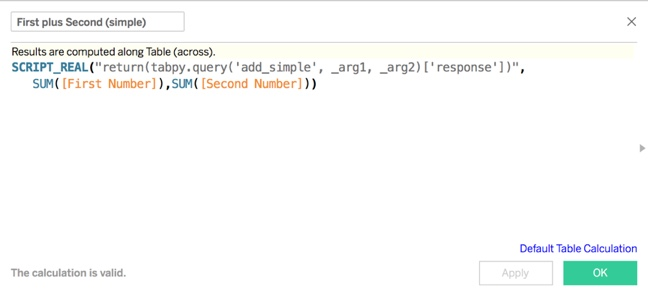

To understand what was wrong, it is convenient to test this function in Python:

In [78]:
# Let us start with something really easy: 1 + 2 = 3
print(add_simple(1,2))  

3


In [79]:
# But now we realize that we could "add" other things
print(add_simple("Hello ", "World"))

Hello World


In [80]:
# What if we add two lists?
x = [1, 2, 3]
y = [10, 20, 30]
print(add_simple(x, y))

[1, 2, 3, 10, 20, 30]


Now we see why Nico got in trouble: When Tableu connects to the tabpy, it sends the server a python list for each parameter required by the invoked function. The list will contain a number of elements equal to number of marks in the view (including sub-totals and grand totals). Therefore, in this example, Tableau sends a list with 10 elements for the parameter **"a"** and a second list of 10 elements for the parameter **"b"**. 
In Python, adding two lists results in the concatenation of the lists. Evaluating **a + b** will result in a list of 20 elements which is not what is needed. In this case, Tableau needed a list of 10 elements to fulfill the logic of the view. 

To demonstrate that this is indeed the problem, let us consider a different version for **add_simple**: 

In [81]:
def add_simple(a, b, verbose = True):
    """ adds two objects and returns an object """
    result = a + b
    if verbose:
        print('-->  add_simple(\n        ',a,',\n        ',b, '\n        ) =', result, '\n')
    return(result)

conn.deploy('add_simple', add_simple, 'suma dos objetos y devuelve un objeto', override = True)


Now go back to Tableau and refresh the view. Once you get the error, go to the *TabPy server console*. This is what you will see:

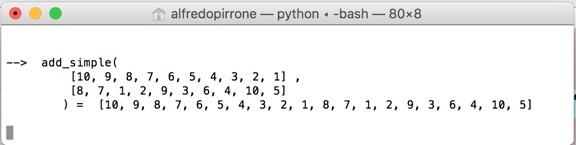

Ok. Now we know what happened for sure. Writing to the console is a convenient way to exactly explore what is going on between Tableau and TabPy. Yet, it is also possible to test the endpoint from python as we will see shortly.

### 3. Some TabPy client functions



   Before discussing different options to implement the add function, let us explore the functionalities provided with the tabpy_client. Remember that you can access the documentation for a module and for its functions using the question mark (?) in ipython (or any IDE using ipython like Spyder).



In [82]:
# You could create an alias for your endpoint (which in this case is your function). 
# Then you will be able to access your endpoint by either name.
conn.alias('add','add_simple')

# Even though it seems that nothing happened, now you have a new endpoint call 'add' (you will see it later

In [83]:
# If you want to execute a function from python in the exact way Tableau will do it, 
#   use the query function...

firstNumber = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
secondNumber = [5, 10, 4, 6, 3, 9, 2, 1, 7, 8]

conn.query('add', firstNumber, secondNumber)


{'model': 'add_simple',
 'response': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 5, 10, 4, 6, 3, 9, 2, 1, 7, 8],
 'uuid': '63ac366f-3f2c-4185-b600-d9b5302425d1',
 'version': 2}

In the example above , notice that we executed the function "add" (alias of "add-simple") passing parameters
"firstNumber" and "secondNumber".

As a response we obtained a dictionary where the returned value is under the key "response".
Now look back at the Calculated Field formula. As you can see, we invoked this function by calling:

    tabpy.query('add_simple', _arg1, _arg2)['response']
    
Observe that we are simply retreiving the value under the key "response" from the returned dictionary.

Of course, as discussed before, using this calculated field will end in an an error. Yet this paragraph shows how to run a deployed endpoint at the tabpy server from python.




In [84]:
conn.query('add', firstNumber, secondNumber)['response']

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 5, 10, 4, 6, 3, 9, 2, 1, 7, 8]

In [85]:
# the method get_status returns a dictionary with info on the status of deployed endpoints
#    and maybe useful for debugging 
for funcName, dic in conn.get_status().items():
    print("\nENDPOINT NAME: "+funcName)
    for name, val in dic.items():
        print("   "+name+" : "+str(val))


ENDPOINT NAME: add_simple
   version : 2
   type : model
   status : LoadSuccessful
   last_error : None

ENDPOINT NAME: add
   version : 1
   type : alias
   status : LoadSuccessful
   last_error : None


In [86]:
# you can also obtain other info about your endpoints using 
for funcName, dic in conn.get_endpoints().items():
    print("\nENDPOINT:" + funcName)
    for name, val in dic.items():
        print("   " + name + " : "+str(val))


ENDPOINT:add_simple
   last_modified_time : 2017-11-20 04:14:27
   type : model
   dependencies : []
   schema : None
   version : 2
   name : add_simple
   creation_time : 2017-11-20 04:14:27
   description : suma dos objetos y devuelve un objeto

ENDPOINT:add
   last_modified_time : 2017-11-20 04:14:27
   type : alias
   dependencies : ['add_simple']
   schema : None
   version : 1
   name : add
   creation_time : 2017-11-20 04:14:27
   description : Alias for add_simple


### 4. Back to Nico's problem

[Zhouyi Zhang](https://community.tableau.com/people/zhouyi.zhang) gave the answer Nico was looking for. Zhouyi used NumPy. But my guess is that Nico was not satisfied with this suggestion because he may have not understood what was wrong in his simpler solution.

In [48] I illustrated the reason why the simple solution does not work. In contrast, the NumPy solution does indeed work because the addition of array_like objects under NumPy behaves as required in this case (more info: [NumPy site](http://www.numpy.org):

In [87]:
def add_numpy(a, b, verbose = True):
    """ adds two array_like objects using numpy and returns a list"""
    import numpy as np
    result = np.add(a, b).tolist()
    if verbose:
        print('-->  add_numpy(\n        ',a,',\n        ',b, '\n        ) =',result, '\n')
    return(result)

# let us deploy the function to have it available in Tableau
conn.deploy('add_numpy', add_numpy, 
            'adds two array_like objects using numpy and returns a list', override = True)

In [96]:
# let us test it locally
print('a =     ', firstNumber)
print('b =     ', secondNumber)
print('a + b = ', add_numpy(firstNumber, secondNumber, verbose = False))

a =      [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
b =      [5, 10, 4, 6, 3, 9, 2, 1, 7, 8]
a + b =  [6, 12, 7, 10, 8, 15, 9, 9, 16, 18]


In [97]:
# and also let us test it remotely
print('a + b = ',conn.query('add_numpy', firstNumber, secondNumber)['response'])

a + b =  [6, 12, 7, 10, 8, 15, 9, 9, 16, 18]


Look at the sheet "Add Numpy" in the enclosed Tableau workbook to see this function working in our sample data.

Yet, Nico looked like he did not want a solution that uses an external library (maybe he didn't care) but Zhouyi also gave the following suggestion:

In [90]:
def add_only_first(a, b, verbose = True):
    """ adds the first objects of two array_like objects, returns an object"""
    if verbose:
        print('-->  add_only_first(\n        ',a,',\n        ',b, '\n        ) =', a[0] + b[0], '\n')
    return(a[0] + b[0])

conn.deploy('add_only_first', add_only_first, 
            'adds the first objects of two array_like objects, returns an object', override = True)

# Let us test it at once on the tabpy server
print('a + b = ',conn.query('add_only_first', firstNumber, secondNumber)['response'])

a + b =  6


This solution did not use NumPy, but this time we got only a single number: the addition of the first two elements 1 + 5.

When Tableau receives a scalar type (a single data item) for the TabPy server, Tableau assigns that value to all marks. See the effect on the sheet **"add_only_first"** in the accompanying workbook. 

Probably, **"add_only_first"** is not an acceptable solution for this example, because lacks generality. It will work well only when we know that the level of detail in use will provide a single element. 



### 5. The answer Nico did not get on March 2017

Anybody who have read "[Tableau Integration with Python - Step by Step](https://community.tableau.com/thread/236479)" probably knows already the solution I am about to give you: develop an endpoint that adds two lists element-by-element with native python: 

In [91]:
def add_lists(a, b, verbose = True):
    """ adds array_like objects item by item, returns an array_like object """
    result = []
    for i in range(len(a)):
        result.append(a[i] + b[i])
    if verbose:
        print('-->  add_lists(\n        ',a,',\n        ',b, '\n        ) =', result, '\n')
    return(result)

conn.deploy('add_lists', add_lists, 
            'adds array_like objects item by item, returns an array_like object', override = True)

# Let us test it at once on the tabpy server
print('a + b = ',conn.query('add_lists', firstNumber, secondNumber)['response'])

a + b =  [6, 12, 7, 10, 8, 15, 9, 9, 16, 18]


### 6. Performance considerations

Let me finish by proposing two performance considerations:

#### 6.1 Always consider different implementation options

You may have learnt that for data science applications it is always advisable to use NumPy structures rather than native python lists for flexibility and performance considerations. 

But too often in our lives we get deceived by paradigms imposed upon us by education, culture or circumstances. we should question them and experiment. 

Let us compare the execution time for **add_numpy** vs **add_lists**:


In [95]:
%timeit add_numpy(firstNumber, secondNumber, verbose = False)
%timeit add_lists(firstNumber, secondNumber, verbose = False)

4.43 µs ± 36.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.64 µs ± 5.91 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


As you can see, **add_lists** is the absolute winner in this case. At least from this point of view.

I am not suggesting you should prefer native python code over NumPy. **I just want to point out that to achieve a decent performance in a Tableau workbook you may need to carefully consider different implementation options**. Do your homework: conceptualize options, develop them, test and measure them, analize and choose the best option for your use case.

#### 6.2 Reduce the number of interactions between Tableau and the TabPy Server

a few microseconds may mean nothing in the overall performance of a Tableau view compared to the overhead required to actually execute an endpoint call.

For example, let us assume we want to control which **add_xxxx** model we want to use. As we have already developed an endpoint for every **add_xxxx** version considered, we could simply create a Tableau parameter (I will call it "WhichSum") and then use a calculated field to execute the desired endpoint. Please refer to the sheet "Add Conditional - SLOW" in the Tableau Workbook.

This is one way to define the calculated field:
   *(I have set NULL for UseSimple because add_simple ends in an error)*:

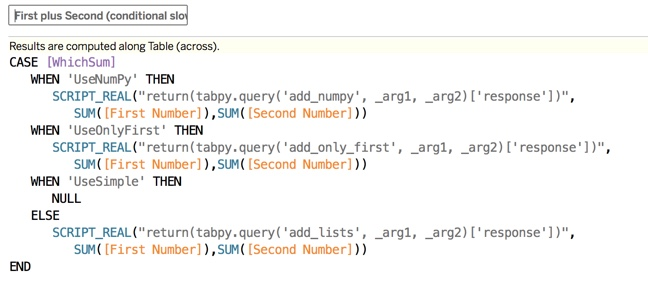

There are no critical errors in this implementation. However, it will be relatively slow.  Tableau is not short-circuiting expressions (at least when TabPy is involved). This means that Tableau will evaluate all references in a calculated field, even though some intermediate results are not logically required to compute the final value.
As a consequence, no matter the value of *[Whichsum]*, Tableau will execute all the endpoints. If these endpoints were models of certain complexity, then the time required to generate the view will be significant.

one way to avoid the overhead and processing involved in executing every endpoint is avoiding multiple calls to the TabPy server. Let us create a single endpoint that will receive the model name as an argument. This new endpoint will implement the model selection logic in python. 

Notice that when we send a Tableau parameter (a scalar) as an argument to a TabPy endpoint, it will be converted to a list where the parameter value will be replicated as many times as marks in the view. Therefore we will reference the parameter in python as *_arg[0]*.

Here is an implementation for the new endpoint. Let us name it **add_with**:

In [93]:
def add_with(modelName, a, b, verbose = True):
    """ adds the first objects of two array_like objects, returns an object"""
    if modelName[0] == 'UseNumPy':
        result = add_numpy(a,b, verbose = False)
    elif modelName[0] == 'UseOnlyFirst':
        result = add_only_first(a,b, verbose = False)
    elif modelName[0] == 'UseSimple':
        result = add_simple(a,b, verbose = False)
    else:
        result = add_lists(a,b, verbose = False)
    if verbose:
        print('*->  add_with(',modelName[0],',\n        ',a,',\n        ',b, '\n        ) =', result, '\n')
    return(result)

conn.deploy('add_with', add_with, 
            'adds array_like objects item by item, uses the designated model', override = True)
            

In the Tableau workbook, look at the "Add Conditional - BETTER" sheet to see it working

To demostrate that this solution is indeed better, is it possible to use Tableau's [performance recording](http://onlinehelp.tableau.com/current/pro/desktop/en-us/perf_record_create_desktop.html "have a look at the Tableau Desktop help") 

This is what I got in one of my tests:
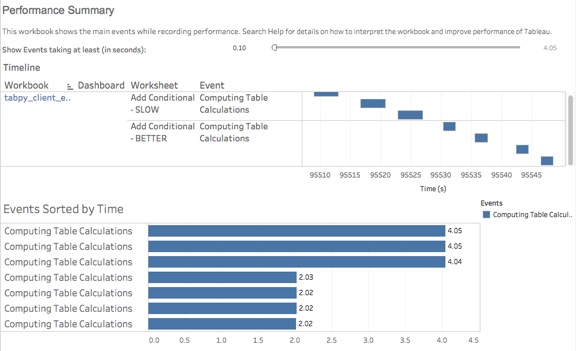

As you can see, we halved execution time with this new approach.

### 7. A final comment

I cannot finish this document without apologizing to Nico. I have created a drama around a simple question that was answered without much explanation. The truth is that, as of Today, Nico Rabi last logged in the Tableau forums on March 17th, 2017. He probably never considered the solutions Zhouyi proposed on April.

I hope that the discussion on Nico's case helped you reading this far, and hopefully getting something useful.

Yours,
Alfredo Pirrone